# Zipline Coding Exercises

In this notebook you will create your own pipeline and create custom factors and filters for it. 

# Load Data

In [2]:

import zipline.data.bundles as bundles
import pandas as pd
from zipline.data.bundles import register, yahoo_NYSE, csvdir

# Specify the bundle name
bundle_name = 'yahoo_NYSE'

start_session = pd.Timestamp('2013-07-01')  # Timezone-naive
end_session = pd.Timestamp('2017-06-30')    # Timezone-naive


register(
    'yahoo_NYSE',
    yahoo_NYSE.yahoo_NYSE(
        tframes=["daily"],
        csvdir="/home/ankit/AI_for_trading/Data/data/eod-quotemedia/"
    )
)

bundle_data = bundles.load('yahoo_NYSE')

/tmp/ipykernel_2166/1568509080.py:12: UserWarning: Overwriting bundle with name 'yahoo_NYSE'
  register(


# TODO: Build an Empty Pipeline with a Screen

In the code below create an empty with a screen that filters the pipeline output for stocks with a 60-day average dollar volume greater than \$50,000.

In [17]:
from zipline.pipeline import Pipeline
from zipline.pipeline.factors import AverageDollarVolume
from zipline.pipeline.domain import US_EQUITIES

# Create a screen for our Pipeline
screen = AverageDollarVolume(window_length = 60) > 500000

# Create an empty Pipeline with the given screen
pipeline = Pipeline(screen=screen, domain=US_EQUITIES)

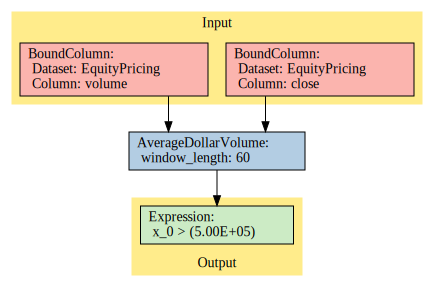

In [18]:
pipeline.show_graph()

# TODO: Create a Pipeline Engine

In the code below, create a data loader that loads our data bundle using Zipline's `USEquityPricingLoader`. Then create a function to be passed to the `get_loader` parameter in the pipeline engine. Using the NYSE trading calendar create a pipeline engine using Zipline's `SimplePipelineEngine`

In [10]:
import zipline.pipeline.engine as engine
from zipline.pipeline.loaders import USEquityPricingLoader
from zipline.pipeline.data import USEquityPricing
from zipline.utils.calendar_utils import get_calendar

# Set the dataloader
pricing_loader = USEquityPricingLoader(bundle_data.equity_daily_bar_reader, bundle_data.adjustment_reader,fx_reader=None)

# Define the function for the get_loader parameter
def choose_loader(column):
    if column not in USEquityPricing.columns:
        raise Exception('Column not in USEquityPricing')
    return pricing_loader


# Set the trading calendar
trading_calendar = get_calendar('NYSE')

# Create a Pipeline engine
engine = engine.SimplePipelineEngine(get_loader=choose_loader,asset_finder=bundle_data.asset_finder)

# TODO: Create Factors and Filters For The Pipeline

### Factors

In the code below, create two factors:

1. **Custom Factor**: Create a custom factor, `percent_difference`,  by combining a 30-day average closing price factor and a 60-average closing price factor. The `percent_difference` factor will calculate the difference between the 30-day and 60-average closing price factors, and will then normalize this difference by the 60-average closing price factor.


2. **Daily Returns Factor**: Create a factor that returns the daily percent change in closing price. To do this, use Zipline's built-in [DailyReturns](https://www.zipline.io/appendix.html#zipline.pipeline.factors.DailyReturns) factor.

Both factors should use the closing prices in the `USEquityPricing`  dataset as inputs. 




### Filters

In the code below, you will create a **Custom Filter**, `tradable_asset`, that returns `True` for the top 20 securities of average dollar volume in a 30 day-window that have a latest closing price above \$30. To do this, you will create two filters first and them combine them. For the first filter, you can use Zipline's built-in factor `AverageDollarVolume()` and its method `.top()` to select the top 20 assets of average dollar volume in a 30 day-window. To get the latest close price of the `USEquityPricing` dataset you can use `USEquityPricing.close.latest`. Finally you can combine these two filters by using the logical operator `&`. 

In [24]:
from zipline.pipeline.factors import SimpleMovingAverage
from zipline.pipeline.factors import DailyReturns
from zipline.pipeline.factors import AverageDollarVolume

# Create the 30-day average closing price factor
closing_30 = SimpleMovingAverage(inputs=[USEquityPricing.close], window_length=30)

# Create the 60-day average closing price factor
closing_60 = SimpleMovingAverage(inputs=[USEquityPricing.close], window_length=60)

# Create the custom factor
percent_difference = (closing_30 - closing_60) / closing_60


# Add the custom factor to the pipeline
# Create the daily returns factor
daily_returns = DailyReturns(inputs=[USEquityPricing.close])

# Create a filter for the top 20 securities of average dollar volume in a 30 day-window
tradable_asset = AverageDollarVolume(window_length=30).top(20)

# Create a filter for the latest closing price above $30
filter_closed = USEquityPricing.close.latest > 30

# Create a custum filter
custom_filter = filter_closed & tradable_asset

# TODO: Add Factors and Filters To The Pipeline

In the code below, add the factors and filters you created above to the pipeline

In [25]:
# Add the custom factor to the pipeline
pipeline.add(percent_difference, 'Percent Difference')

# Add the daily returns factor to the pipeline
pipeline.add(daily_returns, 'Daily Returns')

# Add the custom filter to the pipeline
pipeline.add(custom_filter, 'Filter')

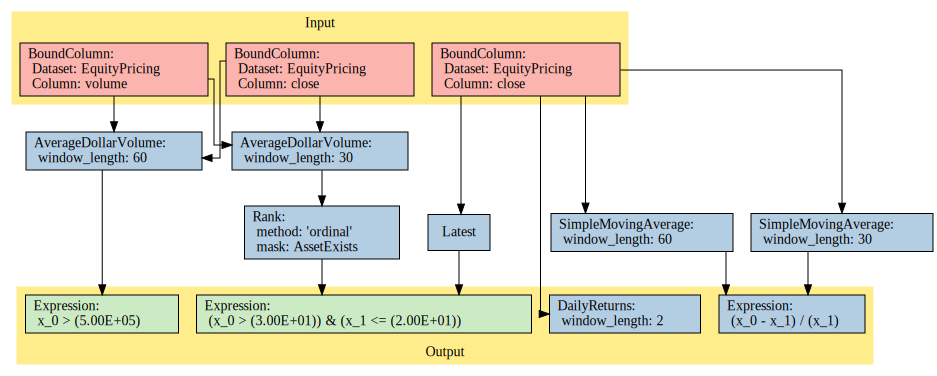

In [26]:
pipeline.show_graph()

# TODO: Run The Pipeline

In the code below, run the pipeline for the dates given

In [29]:

# Set starting and end dates
start_session = '2014-01-06'
end_session = '2016-01-05'

start_date = pd.Timestamp(start_session)
end_date = pd.Timestamp(end_session)

# Run our pipeline for the given start and end dates
output = engine.run_pipeline(pipeline, start_date, end_date)


# Display the pipeline output
output.head()

Percent Difference  Daily Returns  Filter
2014-01-06 Equity(0 [A])               0.035614       0.012635   False
           Equity(1 [AAL])             0.055888       0.046530   False
           Equity(2 [AAP])             0.050904       0.028613   False
           Equity(3 [AAPL])            0.033973      -0.021969   False
           Equity(4 [ABBV])            0.032882       0.006156   False

## Solution

[Solution notebook](zipline_coding_exercises_solution.ipynb)